# Near-Earth Object Data Exploration

This notebook explores the NASA NEO close approach data, providing insights into the dataset structure, data quality, and basic statistics.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from pathlib import Path
import sys
import importlib.util

# Add scripts to path
sys.path.append('../scripts')

# Import modules using importlib to handle numeric filenames
try:
    spec = importlib.util.spec_from_file_location("data_ingestion", "../scripts/02_data_ingestion.py")
    data_ingestion = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(data_ingestion)
    NEODataIngester = data_ingestion.NEODataIngester
    print("✓ NEODataIngester imported successfully")
except Exception as e:
    print(f"⚠️ Could not import NEODataIngester: {e}")

try:
    spec = importlib.util.spec_from_file_location("duckdb_setup", "../scripts/03_duckdb_setup.py")
    duckdb_setup = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(duckdb_setup)
    DuckDBManager = duckdb_setup.DuckDBManager
    print("✓ DuckDBManager imported successfully")
except Exception as e:
    print(f"⚠️ Could not import DuckDBManager: {e}")

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

print("Libraries imported successfully!")

✓ NEODataIngester imported successfully
✓ DuckDBManager imported successfully
Libraries imported successfully!


## 1. Load and Examine the Data

In [2]:
# Connect to the database
try:
    conn = duckdb.connect('../space_analytics.db')
    print("✓ Connected to space analytics database")
except:
    # Fallback: load from CSV if database doesn't exist
    print("Database not found, loading from CSV...")
    data_files = list(Path('../data/raw').glob('neo_data_*.csv'))
    if data_files:
        df = pd.read_csv(data_files[0])
        conn = duckdb.connect(':memory:')
        conn.execute('CREATE TABLE neo_approaches AS SELECT * FROM df')
        print(f"✓ Loaded data from {data_files[0]}")
    else:
        print("❌ No data found. Please run the data ingestion script first.")

✓ Connected to space analytics database


In [3]:
# Get basic dataset information
query = """
SELECT 
    COUNT(*) as total_records,
    COUNT(DISTINCT des) as unique_objects,
    MIN(approach_year) as earliest_year,
    MAX(approach_year) as latest_year,
    COUNT(CASE WHEN h IS NOT NULL THEN 1 END) as records_with_magnitude,
    COUNT(CASE WHEN dist IS NOT NULL THEN 1 END) as records_with_distance
FROM neo_approaches
"""

dataset_info = conn.execute(query).df()
print("Dataset Overview:")
print(f"  Total Records: {dataset_info['total_records'].iloc[0]:,}")
print(f"  Unique Objects: {dataset_info['unique_objects'].iloc[0]:,}")
print(f"  Year Range: {dataset_info['earliest_year'].iloc[0]} - {dataset_info['latest_year'].iloc[0]}")
print(f"  Records with Magnitude: {dataset_info['records_with_magnitude'].iloc[0]:,}")
print(f"  Records with Distance: {dataset_info['records_with_distance'].iloc[0]:,}")

Dataset Overview:
  Total Records: 50,000
  Unique Objects: 13,337
  Year Range: 1900 - 1966
  Records with Magnitude: 49,957
  Records with Distance: 50,000


In [4]:
# Examine the data structure
sample_data = conn.execute("SELECT * FROM neo_approaches LIMIT 10").df()
print("Sample Data:")
display(sample_data)

print("\nColumn Information:")
print(sample_data.info())

Sample Data:


,des,orbit_id,jd,cd,dist,dist_min,dist_max,v_rel,v_inf,t_sigma_f,h,fullname,approach_year
0,170903,186,2.415021e+06,1900-01-01 00:38:00,0.092618,0.092467,0.092769,16.739122,16.737403,00:09,18.20,170903 (2004 WS2),1900
1,2006 XO4,16,2.415021e+06,1900-01-01 03:13:00,0.114291,0.114273,0.114310,7.397204,7.394052,00:18,23.40,(2006 XO4),1900
2,2013 WU45,18,2.415021e+06,1900-01-01 22:29:00,0.169548,0.169546,0.169549,13.709359,13.708212,< 00:01,20.36,(2013 WU45),1900
3,2018 BM3,12,2.415021e+06,1900-01-01 22:41:00,0.076326,0.072808,0.079849,16.925485,16.923422,02:38,21.99,(2018 BM3),1900
4,313552,68,2.415022e+06,1900-01-02 03:06:00,0.136282,0.136270,0.136293,15.948335,15.947109,00:01,20.95,313552 (2003 BX33),1900
5,417217,96,2.415023e+06,1900-01-03 02:44:00,0.102725,0.102665,0.102784,19.137955,19.136600,00:02,19.52,417217 (2005 YS),1900
6,2016 EC157,13,2.415023e+06,1900-01-03 04:57:00,0.157256,0.157254,0.157258,7.514845,7.512590,< 00:01,23.60,(2016 EC157),1900
7,2020 BN7,6,2.415024e+06,1900-01-04 02:16:00,0.089661,0.088258,0.091431,5.258116,5.252461,1_13:09,23.80,(2020 BN7),1900
8,2017 MW4,18,2.415024e+06,1900-01-04 02:18:00,0.061300,0.061291,0.061310,17.591642,17.589171,00:01,20.05,(2017 MW4),1900
9,2023 GC2,2,2.415024e+06,1900-01-04 06:05:00,0.166960,0.166923,0.166996,4.299705,4.295992,09:59,27.29,(2023 GC2),1900



Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   des            10 non-null     object        
 1   orbit_id       10 non-null     object        
 2   jd             10 non-null     float64       
 3   cd             10 non-null     datetime64[ns]
 4   dist           10 non-null     float64       
 5   dist_min       10 non-null     float64       
 6   dist_max       10 non-null     float64       
 7   v_rel          10 non-null     float64       
 8   v_inf          10 non-null     float64       
 9   t_sigma_f      10 non-null     object        
 10  h              10 non-null     float64       
 11  fullname       10 non-null     object        
 12  approach_year  10 non-null     int32         
dtypes: datetime64[ns](1), float64(7), int32(1), object(4)
memory usage: 1.1+ KB
None


## 2. Data Quality Assessment

In [5]:
# Assess data quality
quality_query = """
SELECT 
    'des' as column_name,
    COUNT(*) as total_count,
    COUNT(CASE WHEN des IS NOT NULL AND des != '' THEN 1 END) as non_null_count,
    ROUND(100.0 * COUNT(CASE WHEN des IS NOT NULL AND des != '' THEN 1 END) / COUNT(*), 2) as completeness_pct
FROM neo_approaches

UNION ALL

SELECT 
    'h' as column_name,
    COUNT(*) as total_count,
    COUNT(CASE WHEN h IS NOT NULL THEN 1 END) as non_null_count,
    ROUND(100.0 * COUNT(CASE WHEN h IS NOT NULL THEN 1 END) / COUNT(*), 2) as completeness_pct
FROM neo_approaches

UNION ALL

SELECT 
    'dist' as column_name,
    COUNT(*) as total_count,
    COUNT(CASE WHEN dist IS NOT NULL THEN 1 END) as non_null_count,
    ROUND(100.0 * COUNT(CASE WHEN dist IS NOT NULL THEN 1 END) / COUNT(*), 2) as completeness_pct
FROM neo_approaches

UNION ALL

SELECT 
    'v_rel' as column_name,
    COUNT(*) as total_count,
    COUNT(CASE WHEN v_rel IS NOT NULL THEN 1 END) as non_null_count,
    ROUND(100.0 * COUNT(CASE WHEN v_rel IS NOT NULL THEN 1 END) / COUNT(*), 2) as completeness_pct
FROM neo_approaches
"""

quality_df = conn.execute(quality_query).df()
print("Data Quality Assessment:")
display(quality_df)

Data Quality Assessment:


,column_name,total_count,non_null_count,completeness_pct
0,des,50000,50000,100.00
1,h,50000,49957,99.91
2,dist,50000,50000,100.00
3,v_rel,50000,50000,100.00


In [ ]:
# Visualize data completeness
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(quality_df['column_name'], quality_df['completeness_pct'])
ax.set_ylabel('Completeness (%)')
ax.set_title('Data Completeness by Column')
ax.set_ylim(0, 100)

# Add value labels on bars
for bar, pct in zip(bars, quality_df['completeness_pct']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{pct}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 3. Distance Analysis

In [6]:
# Distance statistics
distance_stats = conn.execute("""
    SELECT 
        COUNT(*) as total_approaches,
        ROUND(MIN(dist), 8) as closest_approach_au,
        ROUND(MAX(dist), 6) as farthest_approach_au,
        ROUND(AVG(dist), 6) as mean_distance_au,
        ROUND(MEDIAN(dist), 6) as median_distance_au,
        COUNT(CASE WHEN dist < 0.01 THEN 1 END) as very_close_approaches,
        COUNT(CASE WHEN dist < 0.05 THEN 1 END) as close_approaches,
        COUNT(CASE WHEN dist < 0.1 THEN 1 END) as notable_approaches
    FROM neo_approaches 
    WHERE dist IS NOT NULL
""").df()

print("Distance Statistics:")
for col in distance_stats.columns:
    print(f"  {col.replace('_', ' ').title()}: {distance_stats[col].iloc[0]}")

Distance Statistics:
  Total Approaches: 50000
  Closest Approach Au: 0.00034653
  Farthest Approach Au: 0.199992
  Mean Distance Au: 0.116943
  Median Distance Au: 0.121589
  Very Close Approaches: 470
  Close Approaches: 7033
  Notable Approaches: 19009


In [ ]:
# Plot distance distribution
distances = conn.execute("SELECT dist FROM neo_approaches WHERE dist IS NOT NULL").df()['dist']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Linear scale histogram
ax1.hist(distances, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Distance (AU)')
ax1.set_ylabel('Frequency')
ax1.set_title('NEO Approach Distance Distribution')

# Log scale histogram
ax2.hist(distances, bins=50, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Distance (AU)')
ax2.set_ylabel('Frequency')
ax2.set_title('NEO Approach Distance Distribution (Log Scale)')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

## 4. Size Analysis (H Magnitude)

In [14]:
# Size distribution analysis
size_analysis = conn.execute("""
    SELECT 
        CASE 
            WHEN h < 18 THEN 'Very Large (>1km)'
            WHEN h < 22 THEN 'Large (140m-1km)' 
            WHEN h < 25 THEN 'Medium (30-140m)'
            ELSE 'Small (<30m)'
        END as size_category,
        COUNT(*) as count,
        ROUND(MIN(dist), 6) as closest_approach_au,
        ROUND(AVG(v_rel), 2) as avg_velocity_kms,
        ROUND(MIN(h), 2) as brightest,
        ROUND(MAX(h), 2) as dimmest
    FROM neo_approaches
    WHERE h IS NOT NULL
    GROUP BY size_category
    ORDER BY MIN(h)
""").df()

print("Size Distribution Analysis:")
display(size_analysis)

Size Distribution Analysis:


,size_category,count,closest_approach_au,avg_velocity_kms,brightest,dimmest
0,Very Large (>1km),1255,0.002340,18.30,10.39,17.99
1,Large (140m-1km),15886,0.000503,15.32,18.00,21.99
2,Medium (30-140m),18626,0.000406,10.73,22.00,24.99
3,Small (<30m),14190,0.000347,8.73,25.00,32.95


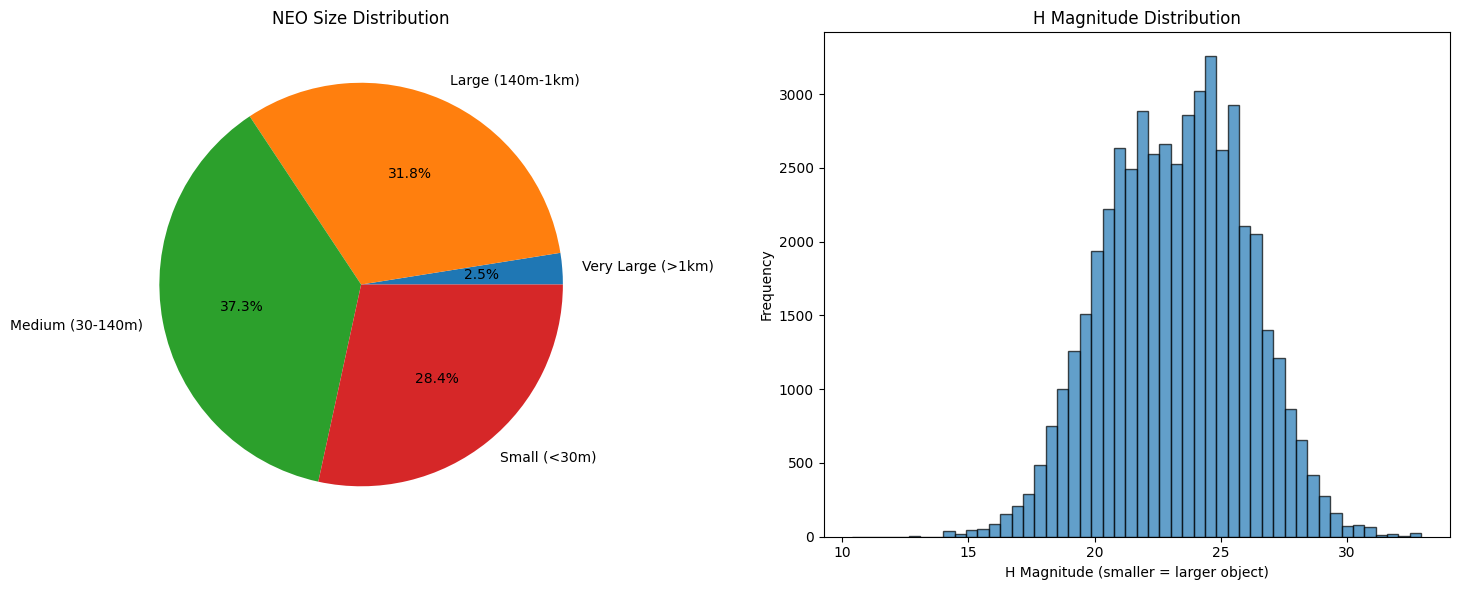

In [15]:
# Visualize size distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart of size categories
ax1.pie(size_analysis['count'], labels=size_analysis['size_category'], autopct='%1.1f%%')
ax1.set_title('NEO Size Distribution')

# H magnitude histogram
h_values = conn.execute("SELECT h FROM neo_approaches WHERE h IS NOT NULL").df()['h']
ax2.hist(h_values, bins=50, alpha=0.7, edgecolor='black')
ax2.set_xlabel('H Magnitude (smaller = larger object)')
ax2.set_ylabel('Frequency')
ax2.set_title('H Magnitude Distribution')

plt.tight_layout()
plt.show()

## 5. Temporal Analysis

In [19]:
# Yearly approach trends
yearly_trends = conn.execute("""
    SELECT 
        approach_year as year,
        COUNT(*) as total_approaches,
        COUNT(DISTINCT des) as unique_objects,
        ROUND(AVG(dist), 6) as avg_distance,
        ROUND(MIN(dist), 6) as closest_approach
    FROM neo_approaches 
    WHERE approach_year IS NOT NULL 
    GROUP BY approach_year 
    ORDER BY approach_year
""").df()

print(f"Yearly trends for {len(yearly_trends)} years:")
display(yearly_trends.head(10))

Yearly trends for 68 years:


,year,total_approaches,unique_objects,avg_distance,closest_approach
0,1900,689,674,0.117529,0.009632
1,1901,636,622,0.115831,0.008629
2,1902,668,658,0.118118,0.004663
3,1903,659,642,0.116887,0.007594
4,1904,676,655,0.119970,0.004716
5,1905,679,661,0.118489,0.002982
6,1906,683,661,0.117420,0.005900
7,1907,665,649,0.118442,0.005827
8,1908,717,696,0.118575,0.007471
9,1909,643,626,0.118952,0.002973


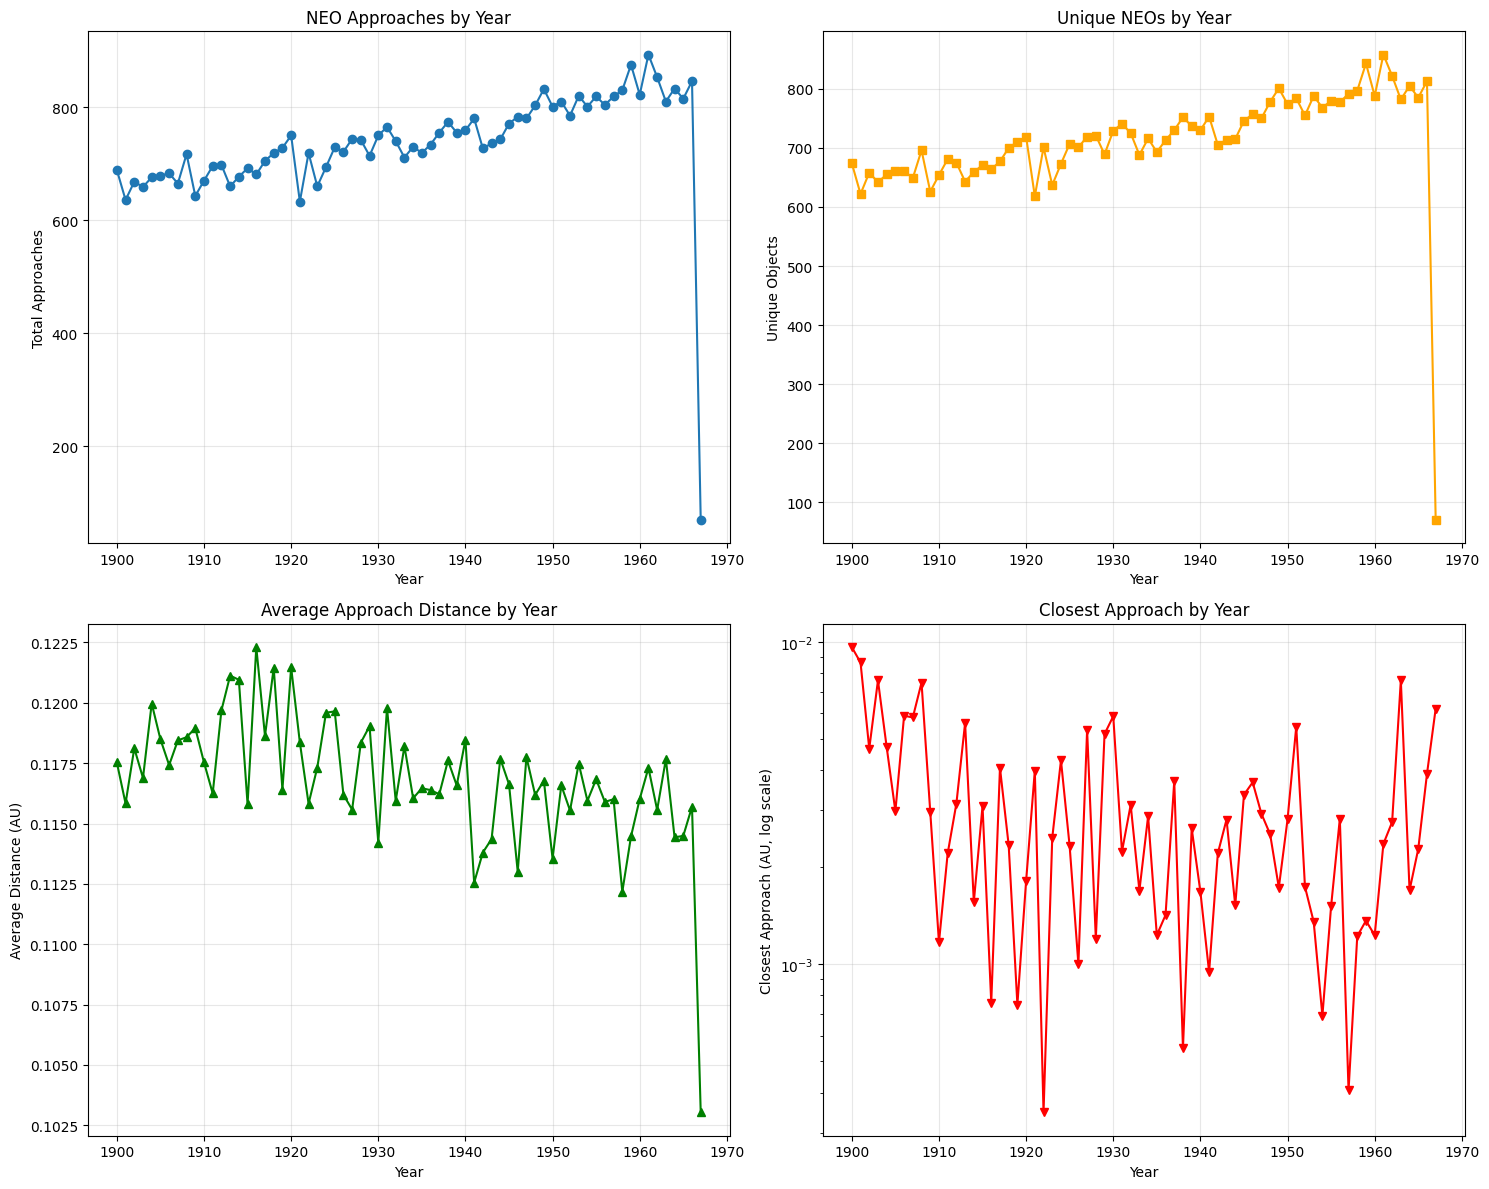

In [20]:
# Plot yearly trends
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Total approaches per year
ax1.plot(yearly_trends['year'], yearly_trends['total_approaches'], marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Approaches')
ax1.set_title('NEO Approaches by Year')
ax1.grid(True, alpha=0.3)

# Unique objects per year
ax2.plot(yearly_trends['year'], yearly_trends['unique_objects'], marker='s', color='orange')
ax2.set_xlabel('Year')
ax2.set_ylabel('Unique Objects')
ax2.set_title('Unique NEOs by Year')
ax2.grid(True, alpha=0.3)

# Average distance over time
ax3.plot(yearly_trends['year'], yearly_trends['avg_distance'], marker='^', color='green')
ax3.set_xlabel('Year')
ax3.set_ylabel('Average Distance (AU)')
ax3.set_title('Average Approach Distance by Year')
ax3.grid(True, alpha=0.3)

# Closest approach each year
ax4.semilogy(yearly_trends['year'], yearly_trends['closest_approach'], marker='v', color='red')
ax4.set_xlabel('Year')
ax4.set_ylabel('Closest Approach (AU, log scale)')
ax4.set_title('Closest Approach by Year')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Risk Assessment Preview

In [21]:
# Simple risk assessment based on size and distance
risky_objects = conn.execute("""
    SELECT 
        des,
        fullname,
        h,
        ROUND(dist, 6) as distance_au,
        ROUND(v_rel, 2) as velocity_kms,
        cd as approach_date,
        CASE 
            WHEN h < 18 AND dist < 0.05 THEN 'VERY_HIGH'
            WHEN h < 20 AND dist < 0.1 THEN 'HIGH'
            WHEN h < 25 AND dist < 0.2 THEN 'MEDIUM'
            ELSE 'LOW'
        END as risk_category
    FROM neo_approaches 
    WHERE h IS NOT NULL AND dist IS NOT NULL
    ORDER BY h ASC, dist ASC
    LIMIT 20
""").df()

print("Top 20 Objects by Size and Proximity:")
display(risky_objects)

# Risk category distribution
risk_distribution = risky_objects['risk_category'].value_counts()
print("\nRisk Category Distribution (Top 20):")
print(risk_distribution)

Top 20 Objects by Size and Proximity:


,des,fullname,h,distance_au,velocity_kms,approach_date,risk_category
0,433,433 Eros (A898 PA),10.39,0.174073,5.92,1931-01-30 04:07:00,MEDIUM
1,1866,1866 Sisyphus (1972 XA),12.48,0.197423,23.07,1959-11-17 08:31:00,MEDIUM
2,1627,1627 Ivar (1929 SH),12.79,0.150180,6.29,1957-07-21 08:58:00,MEDIUM
3,1627,1627 Ivar (1929 SH),12.79,0.166522,6.55,1929-07-19 10:23:00,MEDIUM
4,2212,2212 Hephaistos (1978 SB),13.50,0.192168,32.57,1927-09-19 21:49:00,MEDIUM
5,5143,5143 Heracles (1991 VL),14.06,0.099855,23.57,1962-07-07 04:32:00,HIGH
6,5143,5143 Heracles (1991 VL),14.06,0.144706,25.83,1939-12-01 17:10:00,MEDIUM
7,5143,5143 Heracles (1991 VL),14.06,0.160509,29.97,1957-07-17 07:47:00,MEDIUM
8,3122,3122 Florence (1981 ET3),14.08,0.052393,13.95,1930-08-29 19:23:00,HIGH
9,4183,4183 Cuno (1959 LM),14.16,0.147375,21.35,1947-12-22 14:28:00,MEDIUM



Risk Category Distribution (Top 20):
risk_category
MEDIUM    18
HIGH       2
Name: count, dtype: int64


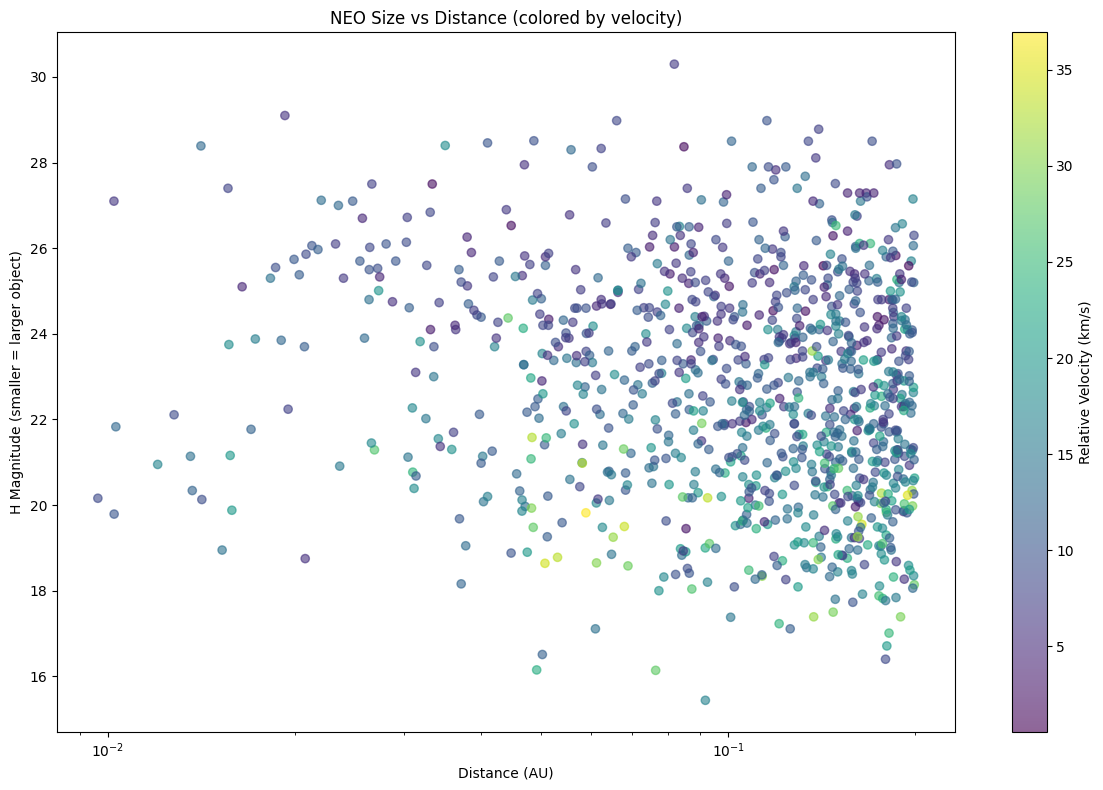

In [22]:
# Scatter plot: Size vs Distance
scatter_data = conn.execute("""
    SELECT h, dist, v_rel
    FROM neo_approaches 
    WHERE h IS NOT NULL AND dist IS NOT NULL AND v_rel IS NOT NULL
    LIMIT 1000
""").df()

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(scatter_data['dist'], scatter_data['h'], 
                    c=scatter_data['v_rel'], cmap='viridis', alpha=0.6)
ax.set_xlabel('Distance (AU)')
ax.set_ylabel('H Magnitude (smaller = larger object)')
ax.set_title('NEO Size vs Distance (colored by velocity)')
ax.set_xscale('log')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Relative Velocity (km/s)')

plt.tight_layout()
plt.show()

## 7. Summary Statistics

In [23]:
# Generate comprehensive summary
summary = conn.execute("""
    SELECT 
        'Total NEO Approaches' as metric,
        COUNT(*)::VARCHAR as value
    FROM neo_approaches
    
    UNION ALL
    
    SELECT 
        'Unique Objects',
        COUNT(DISTINCT des)::VARCHAR
    FROM neo_approaches
    
    UNION ALL
    
    SELECT 
        'Closest Approach (AU)',
        ROUND(MIN(dist), 8)::VARCHAR
    FROM neo_approaches WHERE dist IS NOT NULL
    
    UNION ALL
    
    SELECT 
        'Largest Object (H mag)',
        ROUND(MIN(h), 2)::VARCHAR
    FROM neo_approaches WHERE h IS NOT NULL
    
    UNION ALL
    
    SELECT 
        'Fastest Object (km/s)',
        ROUND(MAX(v_rel), 2)::VARCHAR
    FROM neo_approaches WHERE v_rel IS NOT NULL
    
    UNION ALL
    
    SELECT 
        'Very Close Approaches (<0.01 AU)',
        COUNT(*)::VARCHAR
    FROM neo_approaches WHERE dist < 0.01
""").df()

print("Dataset Summary:")
print("=" * 40)
for _, row in summary.iterrows():
    print(f"{row['metric']:.<30} {row['value']}")

print("\n✓ Data exploration completed!")
print("\nNext steps:")
print("1. Run performance analysis notebook")
print("2. View presentation demo notebook")
print("3. Execute the main scripts for full analysis")

Dataset Summary:
Total NEO Approaches.......... 50000
Unique Objects................ 13331
Closest Approach (AU)......... 0.00034653
Largest Object (H mag)........ 10.39
Fastest Object (km/s)......... 70.56
Very Close Approaches (<0.01 AU) 471

✓ Data exploration completed!

Next steps:
1. Run performance analysis notebook
2. View presentation demo notebook
3. Execute the main scripts for full analysis


In [24]:
# Clean up
conn.close()
print("Database connection closed.")

Database connection closed.
